In [1]:
#Módulos

from scipy import optimize
from scipy.integrate import odeint
from IPython.display import display, Math, Markdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import locale
import datetime

locale.setlocale(locale.LC_TIME, 'es_ES')

'es_ES'

In [2]:
# Modelo SIR

def SIRderiv(params, t, N, beta, gamma):
    S, I, R = params
    dS = -beta*I*S/N
    dI = beta*I*S/N - gamma*I
    dR = gamma*I
    return dS, dI, dR

In [3]:
# Parseo y procesamiento de datos reales

rawData = pd.read_csv("casos_chile.csv")
procData = rawData[["Casos Nuevos"]]
procData.rename(columns={"Casos Nuevos":"Casos diarios"}, inplace=True)

newRecoveredPerDay = []
lastDayRecovered = 0
for currentDayRecovered in rawData["Recuperados"]:
    newRecoveredPerDay.append(currentDayRecovered - lastDayRecovered)
    if not np.isnan(currentDayRecovered):
        lastDayRecovered = currentDayRecovered
procData["Recuperados diarios"] = newRecoveredPerDay
        
newDeceasedPerDay = []
lastDayDeceased = 0
for currentDayDeceased in rawData["Fallecidos"]:
    newDeceasedPerDay.append(currentDayDeceased - lastDayDeceased)
    if not np.isnan(currentDayDeceased):
        lastDayDeceased = currentDayDeceased
procData["Fallecidos diarios"] = newDeceasedPerDay

/tmp/ipykernel_5587/3487492198.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procData.rename(columns={"Casos Nuevos":"Casos diarios"}, inplace=True)
/tmp/ipykernel_5587/3487492198.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procData["Recuperados diarios"] = newRecoveredPerDay
/tmp/ipykernel_5587/3487492198.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [4]:
# Adelantar datos de infectados
daysMoved = 0

if daysMoved > 0:
    initialInfected = 0
    for iii in procData["Casos diarios"].tolist()[0:daysMoved-1]:
        initialInfected += iii
    correctedInfectedPerDay = [initialInfected]
    for iii in procData["Casos diarios"].tolist()[daysMoved:]:
        correctedInfectedPerDay.append(iii)
    newColumn = pd.DataFrame({'Casos corregidos':correctedInfectedPerDay})
    procData = pd.concat([procData,newColumn], axis=1)
    infectedDataToUse = "Casos corregidos"
else:
    initialInfected = 2
    infectedDataToUse = "Casos diarios"

# Procesar datos para modelo SIR
totalInfectedPerDay = []
totalRemovedPerDay = []
#Condiciones iniciales
currentInfected = 0
currentRemoved = 0
for index, row in procData.iterrows():
    newInfected, newRecovered, newDeceased = row[infectedDataToUse], row["Recuperados diarios"], row["Fallecidos diarios"]
    #if not np.isnan(newInfected):
    currentInfected += newInfected
    if not np.isnan(newRecovered):
        currentInfected -= newRecovered
        currentRemoved += newRecovered
    if not np.isnan(newDeceased):
        currentInfected -= newDeceased
        currentRemoved += newDeceased
    totalInfectedPerDay.append(currentInfected)
    totalRemovedPerDay.append(currentRemoved)

SIRExperimentalData = pd.DataFrame()
SIRExperimentalData["Infectados"] = totalInfectedPerDay
SIRExperimentalData["Removidos"] = totalRemovedPerDay
SIRExperimentalData.index.names = ["Día"]
SIRExperimentalData.reset_index(inplace=True)

In [5]:
#Optimizar parámetro de contagio

def calculate_standard_error(observedResults, predictedResults):
    if (len(observedResults) != len(predictedResults)):
        print("ERROR: Los resultados observados y predichos no poseen el mismo número de datos")
        return 0
    squaredDeviations = []
    for obsY, predY in zip(observedResults, predictedResults):
        squaredDeviations.append(np.power(obsY-predY, 2))
    return np.sqrt( np.sum(squaredDeviations)/len(observedResults) )

def calculate_correlation_coefficient(observedResults, predictedResults):
    if (len(observedResults) != len(predictedResults)):
        print("ERROR: Los resultados observados y predichos no poseen el mismo número de datos")
        return 0
    correlation_matrix = np.corrcoef(observedResults, predictedResults)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared

def chi_squared(observedResults, predictedResults):
    if (len(observedResults) != len(predictedResults)):
        print("ERROR: Los resultados observados y predichos no poseen el mismo número de datos")
        return 0
    squaredDeviations = []
    for obsY, predY in zip(observedResults, predictedResults):
        squaredDeviations.append(np.power(obsY-predY, 2))
    return np.sum(squaredDeviations)
        
def integrate_SIR_model(initialConditions, days, population, beta, gamma):
    ret = odeint(SIRderiv, initialConditions, days, args=(population, beta, gamma))
    suceptible, infected, removed = ret.T
    resultDataFrame = pd.DataFrame()
    resultDataFrame["Día"] = days
    resultDataFrame["Suceptibles"] = suceptible
    resultDataFrame["Infectados"] = infected
    resultDataFrame["Removidos"] = removed
    return resultDataFrame

def clean_data(dataFrame, columnOfInterest):
    dirtyColumn = dataFrame[[columnOfInterest]]
    cleanColumn = dirtyColumn.dropna()
    return cleanColumn

def error_from_gamma(gamma, beta, initialConditions, population, experimentalData):
    cleanData = clean_data(experimentalData, "Removidos")
    resultingSIR = integrate_SIR_model(initialConditions, np.arange(len(cleanData)), population, beta, gamma)
    experimentalInfected = experimentalData["Removidos"].to_numpy()
    predictedInfected = resultingSIR["Removidos"].to_numpy()
    return calculate_standard_error(experimentalInfected, predictedInfected)

def error_from_beta(beta, gamma, initialConditions, population, experimentalData):
    resultingSIR = integrate_SIR_model(initialConditions, np.arange(len(experimentalData)), population, beta, gamma)
    experimentalInfected = experimentalData["Infectados"].to_numpy()
    predictedInfected = resultingSIR["Infectados"].to_numpy()
    return calculate_standard_error(experimentalInfected, predictedInfected)

def error_on_infected(parameters, gamma, initialInfected, initialRemoved, experimentalData):
    beta, population = parameters
    initialSuceptible = population - (initialRemoved + initialInfected)
    initialConditions = (initialSuceptible, initialInfected, initialRemoved)
    resultingSIR = integrate_SIR_model(initialConditions, np.arange(len(experimentalData)), population, beta, gamma)
    experimentalInfected = experimentalData["Infectados"].to_numpy()
    predictedInfected = resultingSIR["Infectados"].to_numpy()
    return chi_squared(experimentalInfected, predictedInfected)

def error_on_removed(parameters, gamma, initialInfected, initialRemoved, experimentalData):
    beta, population = parameters
    initialSuceptible = population - (initialRemoved + initialInfected)
    initialConditions = (initialSuceptible, initialInfected, initialRemoved)
    resultingSIR = integrate_SIR_model(initialConditions, np.arange(len(experimentalData)), population, beta, gamma)
    experimentalInfected = experimentalData["Removidos"].to_numpy()
    predictedInfected = resultingSIR["Removidos"].to_numpy()
    return calculate_standard_error(experimentalInfected, predictedInfected)

def find_best_fit(parameters, recoveryTime, maxPopulation, experimentalData):
    #Parsear condiciones iniciales
    initialInfected = experimentalData.loc[0,"Infectados"]
    initialRemoved = experimentalData.loc[0, "Removidos"]
    #Procesar parámetros
    gamma = 1/recoveryTime
    #Optimizar parámetros
    if True:
        prevParamOptimizationResult = optimize.minimize(error_on_removed,
                                                       x0=parameters,
                                                       args=(gamma, initialInfected, initialRemoved, experimentalData),
                                                       bounds=((0.057, 0.6425), (maxPopulation/1e4, maxPopulation)),
                                                       tol=1e-10)
        parameters = prevParamOptimizationResult.x
    firstParamOptimizationResult = optimize.minimize(error_on_infected,
                                                        x0=parameters,
                                                        args=(gamma, initialInfected, initialRemoved, experimentalData),
                                                        bounds=((0.057, 0.6425), (maxPopulation/1e4, maxPopulation)),
                                                        tol=1e-10)
    parameters = firstParamOptimizationResult.x
    print("I: {0}\tR: {1}\tR0: {2}\tN: {3}".format(initialInfected, initialRemoved, round(parameters[0]*recoveryTime,2), int(parameters[1])))
    return parameters

In [6]:
#Dividir los datos en bins de X días.

binSize = 7

totalDataSampleSize = len(SIRExperimentalData)
dataSamples = []
lowerLimit = 0
upperLimit = binSize
while upperLimit < totalDataSampleSize:
    dataSamples.append(SIRExperimentalData.iloc[lowerLimit:upperLimit].reset_index())
    lowerLimit += binSize
    upperLimit += binSize

In [7]:
def displayComparisonPlot(experimentalData, optimizedParameters, recoveryTime):
    #Procesar parámetros
    beta, population = optimizedParameters
    gamma = 1/recoveryTime
    #Crear condiciones iniciales
    initialInfected = experimentalData.loc[0,"Infectados"]
    initialRemoved = experimentalData.loc[0, "Removidos"]
    initialSuceptible = population - (initialInfected + initialRemoved)
    initialConditions = (initialSuceptible, initialInfected, initialRemoved)
    #Calcular SIR
    optimizedSIR = integrate_SIR_model(initialConditions, np.arange(len(experimentalData)), population, beta, gamma)
    #Graficar los resultados y compararlos
    figure = plt.figure()
    SIRInfectedPlot =  figure.add_subplot(111)
    SIRInfectedPlot.plot(experimentalData["Día"], experimentalData["Infectados"], 'o', color="C1")
    SIRInfectedPlot.plot(experimentalData["Día"], optimizedSIR["Infectados"], color="C3")
    plt.ylabel("Infectados")
    #plt.yscale("log")
    plt.xlabel("Días desde el primer contagio")
    plt.show()

Desde el martes 03 de marzo hasta el lunes 09 de marzo
I: 2.0	R: 0.0	R0: 5.4	N: 3518500


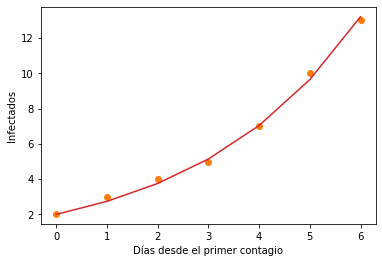

Desde el martes 10 de marzo hasta el lunes 16 de marzo
I: 17.0	R: 0.0	R0: 5.9	N: 3518499


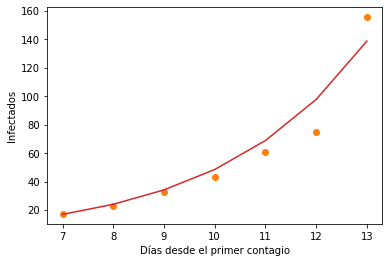

Desde el martes 17 de marzo hasta el lunes 23 de marzo
I: 201.0	R: 0.0	R0: 4.13	N: 3518499


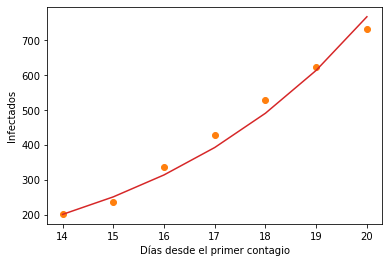

Desde el martes 24 de marzo hasta el lunes 30 de marzo
I: 910.0	R: 12.0	R0: 3.25	N: 3518499


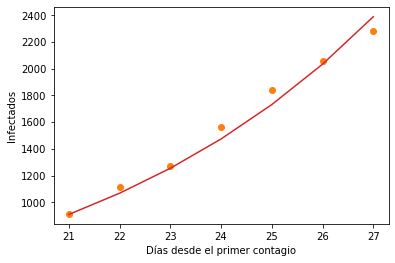

Desde el martes 31 de marzo hasta el lunes 06 de abril
I: 2570.0	R: 168.0	R0: 2.12	N: 3518499


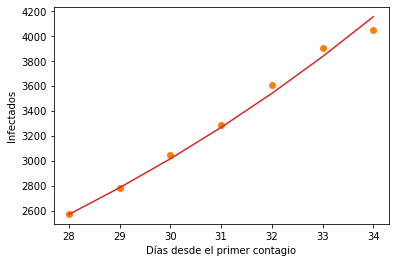

Desde el martes 07 de abril hasta el lunes 13 de abril
I: 4175.0	R: 941.0	R0: 1.55	N: 3518503


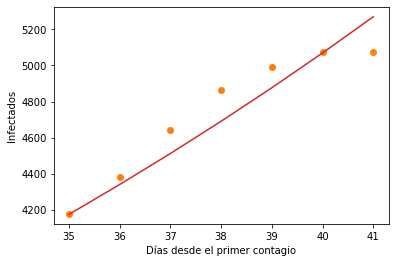

Desde el martes 14 de abril hasta el lunes 20 de abril
I: 5179.0	R: 2738.0	R0: 1.27	N: 3518505


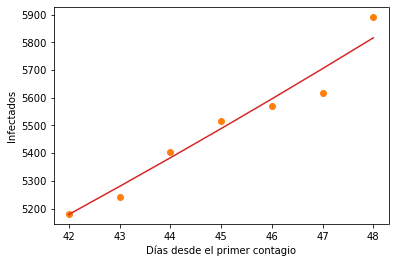

Desde el martes 21 de abril hasta el lunes 27 de abril
I: 5716.0	R: 5116.0	R0: 1.18	N: 3518505


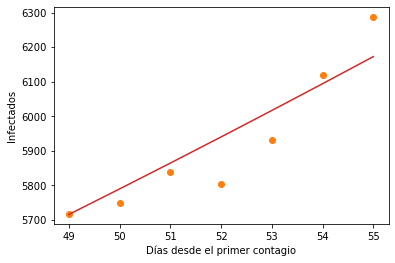

Desde el martes 28 de abril hasta el lunes 04 de mayo
I: 6448.0	R: 7917.0	R0: 2.06	N: 3518501


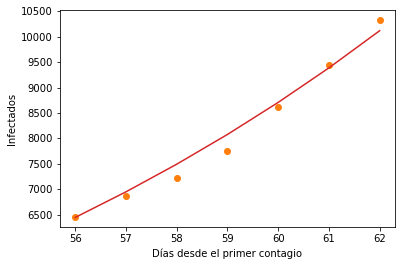

Desde el martes 05 de mayo hasta el lunes 11 de mayo
I: 11031.0	R: 10985.0	R0: 1.92	N: 3518528


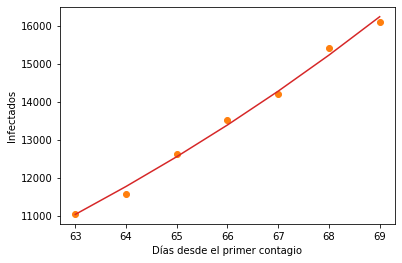

Desde el martes 12 de mayo hasta el lunes 18 de mayo
I: 17231.0	R: 14460.0	R0: 2.0	N: 3518528


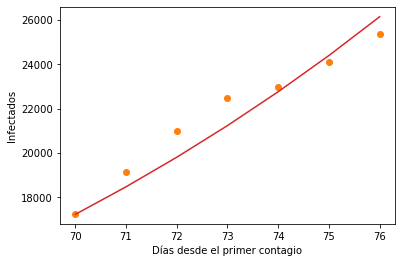

Desde el martes 19 de mayo hasta el lunes 25 de mayo
I: 27533.0	R: 22016.0	R0: 2.14	N: 3519229


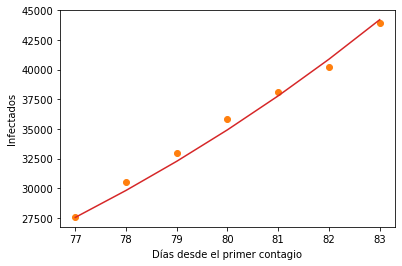

In [8]:
import datetime
zeroDay = datetime.date(2020,3,3)

def print_date_range(dataFraction):
    dataFractionFirstDay = int(dataFraction.loc[0, "Día"])
    dataFractionLastDay = int(dataFraction.loc[len(dataFraction)-1, "Día"])
    firstDay = zeroDay + datetime.timedelta(days=dataFractionFirstDay)
    lastDay = zeroDay + datetime.timedelta(days=dataFractionLastDay)
    firstDayString = firstDay.strftime("%A %d de %B")
    lastDayString = lastDay.strftime("%A %d de %B")
    print("Desde el {0} hasta el {1}".format(firstDayString, lastDayString))

maxPopulation = 19107216 #Fuente: INE

recoveryTime = 14.0
R0 = 2.9

beta = (R0/recoveryTime)
initialPopulation = 7.037e6/2

parameters = (beta, initialPopulation)

optimizedParameters = []
for dataFraction in dataSamples:
    print_date_range(dataFraction)
    newParameters = find_best_fit(parameters, recoveryTime, maxPopulation, dataFraction)
    optimizedParameters.append(newParameters)
    parameters = newParameters
    displayComparisonPlot(dataFraction, newParameters, recoveryTime)

I: 25386.0	R: 20643.0	R0: 1.94	N: 3515157
Desde el lunes 18 de mayo hasta el lunes 01 de junio


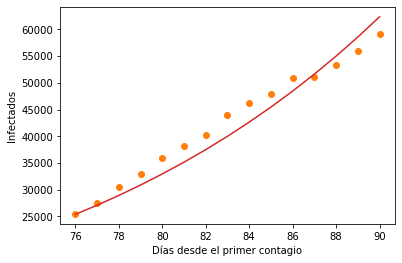

In [461]:
#Análisis de los últimos días.
proyectionLenght = 15

totalDataSampleSize = len(SIRExperimentalData)
upperLimit = totalDataSampleSize
lowerLimit = upperLimit-proyectionLenght
lastTenDaysDataframe = SIRExperimentalData.iloc[lowerLimit:upperLimit].reset_index()

tenDaysParameters = find_best_fit(parameters, recoveryTime, maxPopulation, lastTenDaysDataframe)
print_date_range(lastTenDaysDataframe)
displayComparisonPlot(lastTenDaysDataframe, tenDaysParameters, recoveryTime)

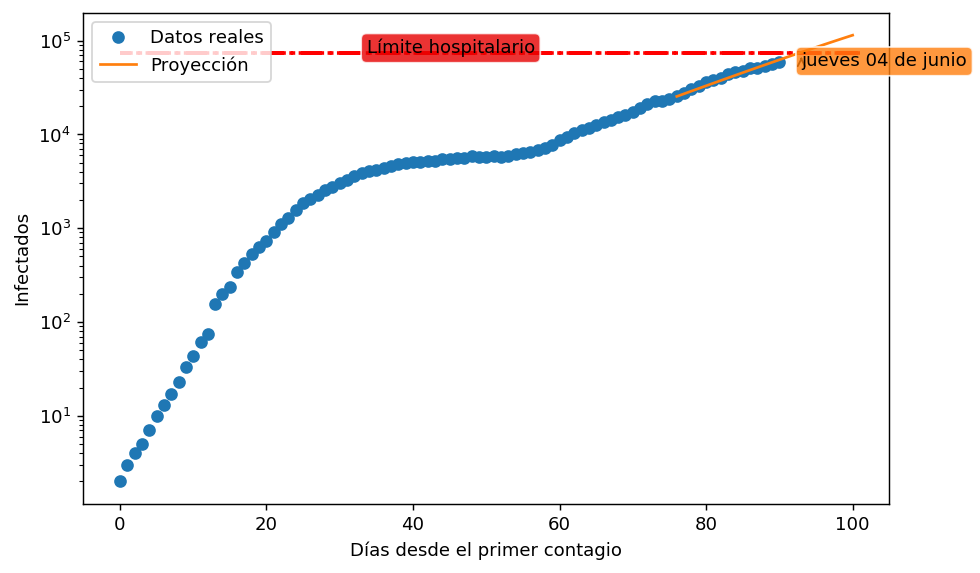

In [466]:
#Proyección en base a últimos días

forwardProyection = 10

initialInfected = lastTenDaysDataframe.loc[0,"Infectados"]
initialRemoved = lastTenDaysDataframe.loc[0, "Removidos"]
beta, population = tenDaysParameters
gamma = 1/recoveryTime
initialSuceptible = population - (initialInfected + initialRemoved)
initialConditions = (initialSuceptible, initialInfected, initialRemoved)

proyectionSIR = integrate_SIR_model(initialConditions, np.arange(lowerLimit, upperLimit+forwardProyection), population, beta, gamma)

ICURate = 1209/59100
ICUBeds = (1209+286)

def seek_icu_doom(proyectionSIR, ICURate, ICUBeds):
    for index, row in proyectionSIR.iterrows():
        if (row["Infectados"]*ICURate > ICUBeds):
            return row["Día"]
    return False

doomDaysFromZero = seek_icu_doom(proyectionSIR,ICURate,ICUBeds)
doomsDay = zeroDay + datetime.timedelta(days=doomDaysFromZero)
doomsDayStr = doomsDay.strftime("%A %d de %B")

figure = plt.figure(figsize=(8,5), dpi=130)
SIRInfectedPlot = figure.add_subplot(111)
SIRInfectedPlot.arrow(0, ICUBeds/ICURate, upperLimit+forwardProyection, 0, color='red', linestyle="-.", linewidth=2.0)
SIRInfectedPlot.annotate('Límite hospitalario', ((upperLimit+forwardProyection)/3, ICUBeds/ICURate), bbox=dict(boxstyle="round", alpha=0.8,
                            fc=(0.9, 0.0, 0.0),
                            ec=(1., 1., 1.)))
SIRInfectedPlot.annotate(s='', xy=(doomDaysFromZero, ICUBeds/ICURate), xytext=(doomDaysFromZero,ICUBeds/ICURate-15000), arrowprops=dict(arrowstyle='->'))
SIRInfectedPlot.annotate(doomsDayStr, (doomDaysFromZero, ICUBeds/ICURate-20000), bbox=dict(boxstyle="round", alpha=0.8,
                            fc="C1",
                            ec=(1., 1., 1.)))
SIRInfectedPlot.plot(SIRExperimentalData["Día"], SIRExperimentalData["Infectados"], 'o', color='C0', label='Datos reales')
SIRInfectedPlot.plot(proyectionSIR["Día"], proyectionSIR["Infectados"],color="C1", label="Proyección")
plt.legend(loc=0)
plt.yscale("log")
plt.ylabel("Infectados")
plt.xlabel("Días desde el primer contagio")
plt.show()

In [463]:
def get_infected(day, SIRModel):
    for index, row in SIRModel.iterrows():
        if day == int(row["Día"]):
            return row["Infectados"]
    return False

def get_removed(day, SIRModel):
    for index, row in SIRModel.iterrows():
        if day == int(row["Día"]):
            return row["Removidos"]
    return False

today = len(SIRExperimentalData)-1
nextDayNewInfected = get_infected(today+1, proyectionSIR) - get_infected(today, proyectionSIR)
nextDayNewRecovered = get_removed(today+1, proyectionSIR) - get_removed(today, proyectionSIR)

newConfirmed = nextDayNewInfected + nextDayNewRecovered

print("Delta de infectados: {0}".format(int(nextDayNewInfected)))

Delta de infectados: 4007


In [464]:
# Ritmo de contagio con ventana móvil

def day_num_to_str(dayNumber):
    zeroDay = datetime.date(2020,3,3)
    currentDay = zeroDay + datetime.timedelta(days=dayNumber)
    return currentDay.strftime("%A %d de %B")



In [51]:
import pandas as pd
import numpy as np
covidData = pd.read_csv("casos_chile.csv")

In [52]:
covidData.columns = ['Date', 'New infected', 'Recovered', 'Deceased']
covidData.T.loc['Deceased'].sum()

20268.0

In [53]:
covidData.T.loc['Deceased'].dropna().sum()

20268.0

In [54]:
covidData.T.loc['Deceased'].fillna(0).sum()

20268.0

In [55]:
covidData.T.loc['Deceased'].fillna(method='bfill').sum()

20288.0

In [56]:
rawData

,Date,New infected,Recovered,Deceased
0,3-Mar-20,2,NaN,NaN
1,4-Mar-20,1,NaN,NaN
2,5-Mar-20,1,NaN,NaN
3,6-Mar-20,1,NaN,NaN
4,7-Mar-20,2,NaN,NaN
...,...,...,...,...
86,28-May-20,4654,35150.0,890.0
87,29-May-20,3695,38598.0,944.0
88,30-May-20,4220,40431.0,997.0
89,31-May-20,4830,42727.0,1054.0
